In [0]:
import tarfile
from google.colab import drive
# drive.mount('/content/drive/')
!fusermount -u drive
drive.mount('/content/drive')

In [0]:
# GPU Version
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(tf.__version__)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import math as ma
import time
from statistics import mean 
from itertools import combinations
import csv
import codecs
import zipfile as zipfile
from sklearn.decomposition import PCA

In [0]:
# Generate data

paraN=64
agentN=10
dataN=200
sampleN=agentN*dataN
mu=np.zeros((1, sampleN))
Sigma=np.eye(sampleN)

# Construct the graph
def generate_w(Idx, agentN):
    G=np.zeros([agentN,agentN])
    for i in Idx:
        G[i[0],i[1]] = 1 
    G=G+G.T
    d=G.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    for i in Idx:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    W=W+W.T
    diag=np.eye(agentN,agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W


epsilon=0.45
p=(1+epsilon)*ma.log(agentN)/agentN
C=0

def erdos(N, p):
    A=np.random.rand(N,N)<p
    A=np.triu(A, 1)
    A=A+A.T
    Lap=np.diag(A*np.ones((N, 1)))-A
    V_L, Lambda_L=np.linalg.eig(Lap)
    if Lambda_L[2,2]<=1e-8:
        C=0
    else:
        C=1
    return A, C

def generate_conn_w(agentN, N, p):
    C=0
    while C==0:
        A1,C=erdos(N, p)
    d=A1.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    A2=A1-np.diag(A1*np.ones((N,1)))
    Idx_n=np.argwhere(A1)
    for i in Idx_n:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    diag=np.eye(agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W


a11 = generate_conn_w(10, 10, 0.95)
a11[9][8] = 0
print(a11)
Idx=[]
for i in range(agentN):
    for j in range(i+1, agentN):
        elem=np.array([[i, j]])
        Idx=Idx+elem.tolist()


def compute_gamma_e(w, i, frac):
    if frac==0:
        return 1/w[i]
    else:
        w_list=list(w)
        w_list.pop(i)
        w_inverse=np.asarray(list(combinations(w_list, frac)))
        w_inverse=[w_inverse[k]+w[i]/len(w_list) for k in range(w_inverse.shape[0])]
    #    print(w_inverse)
    #    w_inverse2=np.concatenate((w_inverse,w[i]*np.ones(w_inverse.shape[0]).T))
        w_inverse_sum=1/((np.sum(w_inverse, axis=1)))
        return np.sum(w_inverse_sum)



In [0]:
agentN=10
x_star_init=np.array([10*np.random.random(size=paraN)-5 for j in range(agentN)])
x_star_init=np.array([[x_star_init[i][j] if abs(x_star_init[i][j])<5 else 5 for j in range(paraN)] for i in range(agentN)])
x_star_consensus_ave=np.sum(x_star_init, axis=0)/agentN
x_star_consensus=np.array([x_star_consensus_ave for j in range(agentN)])
p=0.75

z_init=np.vstack((x_star_init, np.zeros((agentN, paraN))))
z_star_consensus_ave=np.sum(x_star_init, axis=0)/(agentN)
z_star_consensus=[z_star_consensus_ave if k< agentN else np.zeros((1, paraN))[0] for k in range(2*agentN)]
#print(z_star_consensus)

In [0]:
# Consensus - Directed DGD


N=5000
epsilon=0.01

'''
x_a1_cons=x_star_init
y_a1_cons=np.ones((agentN, 1))
x_a1_hat=np.zeros((agentN, paraN))
x_a2_cons=x_star_init
#mu, sigma = 0, 0.0001
'''

def directed_dp_con(N, sel_num, agentN, paraN, epsilon, sigma, mode):

# N: number of iterations
# sel_num: number of sparsified entries
# agentN: number of nodes in the network, n
# paraN: size of the local vectors, d
# epsilon: mixing matrix parameter, \tau
# sigma: noise standard deviation
# mode: "f" - non-private, "dp" - private

    z_a1_cons=z_init
    loss_z_cons=[]
    for i in range(int(N)):
        z_a1_cons_col=np.zeros((agentN*2, paraN))
        '''
        m_idm = np.zeros((agentN, paraN))
        for m in range(agentN):
          m_list=list(range(paraN))
          m_num=int(ma.floor(len(m_list)*sel_num))
          m_id=random.sample(m_list,m_num)
          m_idm[m][m_id] = 1
        '''
        for j in range(paraN):
            # Construct Matrix M
            # Mechanism 1
            A=np.random.random((agentN,agentN))
            B=np.random.random((agentN, agentN))
            A_new=np.array([A[k] for k in range(agentN)])
            B_new=np.array([B[k] for k in range(agentN)])
            # Mechanism 2
            '''
            p=0.95
            Wk=generate_conn_w(agentN, agentN, p)
            Wk[agentN-1][agentN-2]=0
            A_new=np.array([Wk[k] for k in range(agentN)])
            B_new=np.array([Wk[k] for k in range(agentN)])
            '''
            # Mechanism 3
            '''
            A=np.random.random((agentN,agentN))
            B=np.random.random((agentN, agentN))
            if i%2==0:
              A=A*A_r
              B=B*A_r
            else:
              A=A*C_r
              B=B*C_r
            A_new=np.array([A[k] for k in range(agentN)])
            B_new=np.array([B[k] for k in range(agentN)])
            '''
            for m in range(agentN):
                w_list=list(range(agentN))
                w_list.pop(m)
                if sel_num=='full':
                    w_num=0
                elif sel_num=='none':
                    w_num=agentN-1
                else:
                    w_num=sel_num
                w_id=random.sample(w_list,w_num)
#                w_id=[k for k in range(agentN) if m_idm[k, j] == 0 and k != m]

                A_new[m][w_id]=0
                B_new[m][w_id]=0

            A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN)]) # Make it row-stochastic            
            B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN)]) #Make it column-stochastic
            B=B.T
            s_idx=np.random.binomial(1, 0.9)
            if s_idx==1:
                A=np.eye(agentN)
                B=np.eye(agentN)
            M_up=np.hstack((A, epsilon*np.eye(agentN)))
            M_down=np.hstack((np.eye(agentN)-A, B-epsilon*np.eye(agentN)))
            M_new=np.vstack((M_up, M_down))

            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons[:, j])
            if i==0 and mode=='dp':
                s = np.random.normal(0, sigma, (1e18, agentN))
                s = np.mean(s, axis=0)
                z_a1_cons_col_noise=np.array([s[k] if k<agentN else 0 for k in range(agentN*2) ])
                z_a1_cons_col[:, j] += z_a1_cons_col_noise
            
        z_a1_cons=np.array([z_a1_cons_col[k] for k in range(2*agentN)])
        z_a1_ave=np.sum(z_a1_cons, axis=0)/(agentN)
        z_a1_consensus=np.array([z_a1_ave for j in range(agentN)])
        z_a1_consensus_xy=np.vstack((z_a1_consensus, np.zeros((agentN, paraN))))
        loss_z_cons.append(LA.norm(z_a1_cons-z_star_consensus))
        print(i)
    return loss_z_cons
    



In [0]:
# Run experiments with different parameters and plot

N=5000
agentN = 10
'''
loss_z_cons_f=directed_dp_con(N, 'full', agentN, paraN, 0.01, 1, 'f')
loss_z_cons_r=directed_dp_con(N, 'full', agentN, paraN, 0.01, 250, 'dp')
loss_z_cons_r1=directed_dp_con(N, 6, agentN, paraN, 0.01, 1, 'f')
loss_z_cons_r2=directed_dp_con(N, 6, agentN, paraN, 0.01, 250, 'dp')
loss_z_cons_r3=directed_dp_con(N, 8, agentN, paraN, 0.01, 1, 'f')
loss_z_cons_r4=directed_dp_con(N, 8, agentN, paraN, 0.01, 250, 'dp')
'''

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
#plt.ylim((1e-10, 1))
y_axis.sort()    
plt.clf
plt.ylim((1e-11, 1e6))
#plt.xlim((1, 2600))
#plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.plot(loss_z_cons_f[:5000], color='r', linestyle="-", label =r"$q = 0, \sigma = 0$")
plt.plot(loss_z_cons_r[:5000], color='g', linestyle="-.", label =r"$q = 0, \sigma = 248, \epsilon = 0.78$")
plt.plot(loss_z_cons_r3[:5000], color='orange', linestyle="-", label =r"$q = 0.6, \sigma = 0$")
plt.plot(loss_z_cons_r4[:5000], color='purple', linestyle="-.", label =r"$q = 0.6, \sigma = 248, \epsilon = 0.31$")
plt.plot(loss_z_cons_r1[:5000], color='b', linestyle="-", label =r"$q = 0.8, \sigma = 0$")
plt.plot(loss_z_cons_r2[:5000], color='y', linestyle="-.", label =r"$q = 0.8, \sigma = 248, \epsilon = 0.16$")

plt.xlabel('iteration t')
plt.ylabel('Residual')
# plt.legend()
plt.legend(bbox_to_anchor=(1.01, 0.98),loc='upper right')
# plt.savefig('/tmp/dp_consensus_5000ite_m1.eps',dpi=600,format='eps')

In [0]:
data_name = '/tmp/consensus.npy'
a2 = np.load(data_name)

# np.save(data_name, [[loss_z_cons_f], [loss_z_cons_r], [loss_z_cons_r3], [loss_z_cons_r4], [loss_z_cons_r1], [loss_z_cons_r2] ])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


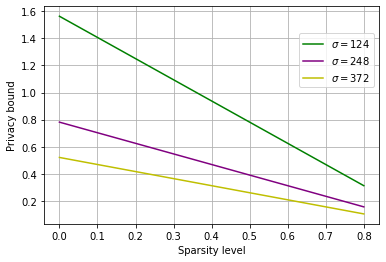

In [10]:
# Plot privacy bound 

q_list = [0.8, 0.6, 0.4, 0.2, 0.0]
eps_list1 = [np.sqrt(64)*5*(1-q_list[i])*np.sqrt(2*np.log(1.25/1e-5))/124 for i in range(5) ]
eps_list2 = [np.sqrt(64)*5*(1-q_list[i])*np.sqrt(2*np.log(1.25/1e-5))/248 for i in range(5) ]
eps_list3 = [np.sqrt(64)*5*(1-q_list[i])*np.sqrt(2*np.log(1.25/1e-5))/372 for i in range(5) ]

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
y_axis.sort()    
plt.clf()
plt.grid()

plt.plot(q_list, eps_list1, color='g', linestyle="-", label =r"$\sigma = 124$")
plt.plot(q_list, eps_list2, color='purple', linestyle="-", label =r"$\sigma = 248$")
plt.plot(q_list, eps_list3, color='y', linestyle="-", label =r"$\sigma = 372$")

plt.xlabel('Sparsity level')
plt.ylabel('Privacy bound')
# plt.legend()
plt.legend(bbox_to_anchor=(1.0,0.9),loc='upper right')
plt.savefig('/tmp/cons_pri.eps',dpi=600,format='eps')

In [0]:
# Experiments for different sizes of network

def directed_dp_thr(N, sel_num, agentN, paraN, epsilon, sigma, mode):

    z_a1_cons=z_init
    loss_z_cons=[]
    for i in range(int(N)):
        z_a1_cons_col=np.zeros((agentN*2, paraN))
        for j in range(paraN):
            # Construct Matrix M
            # Mechanism 1
            A=np.random.random((agentN,agentN))
            B=np.random.random((agentN, agentN))
            A_new=np.array([A[k] for k in range(agentN)])
            B_new=np.array([B[k] for k in range(agentN)])
            # Mechanism 2
#            p=0.95
#            Wk=generate_conn_w(agentN, agentN, p)
#            Wk[agentN-1][agentN-2]=0
#            A_new=np.array([Wk[k] for k in range(agentN)])
#            B_new=np.array([Wk[k] for k in range(agentN)])
            
            for m in range(agentN):
                w_list=list(range(agentN))
                w_list.pop(m)
                if sel_num=='full':
                    w_num=0
                elif sel_num=='none':
                    w_num=agentN-1
                else:
                    w_num=sel_num
                w_id=random.sample(w_list,w_num)

                A_new[m][w_id]=0
                B_new[m][w_id]=0

            A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN)]) # Make it row-stochastic            
            B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN)]) #Make it column-stochastic
            B=B.T
            s_idx=np.random.binomial(1, 0.9)
            if s_idx==1:
                A=np.eye(agentN)
                B=np.eye(agentN)
            M_up=np.hstack((A, epsilon*np.eye(agentN)))
            M_down=np.hstack((np.eye(agentN)-A, B-epsilon*np.eye(agentN)))
            M_new=np.vstack((M_up, M_down))

            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons[:, j])
            if i==0 and mode=='dp':
                s = np.random.normal(0, sigma, (1e18, agentN))
                s = np.mean(s, axis=0)
                z_a1_cons_col_noise=np.array([s[k, 0] if k<agentN else 0 for k in range(agentN*2) ])
                z_a1_cons_col[:, j] += z_a1_cons_col_noise
            

        #    z_a1_cons=M_new.dot(z_a1_cons)
        z_a1_cons=np.array([z_a1_cons_col[k] for k in range(2*agentN)])
        z_a1_ave=np.sum(z_a1_cons, axis=0)/(agentN)
        z_a1_consensus=np.array([z_a1_ave for j in range(agentN)])
        z_a1_consensus_xy=np.vstack((z_a1_consensus, np.zeros((agentN, paraN))))
        loss_z_cons.append(LA.norm(z_a1_cons-z_star_consensus))
        if i%100==0:
          print(i)
        if loss_z_cons[-1]<= 1e-10:
          return i

    

In [0]:
# Run experiments for different sizes of network

'''
num_f1=directed_dp_thr(N, "full", 10, paraN, 0.01, 1, 'f')
num_f2=directed_dp_thr(N, "full", 20, paraN, 0.01, 1, 'f')
num_f3=directed_dp_thr(N, "full", 30, paraN, 0.01, 1, 'f')
num_f4=directed_dp_thr(N, "full", 40, paraN, 0.01, 1, 'f')
'''
num_fp1=directed_dp_thr(N, "full", 10, paraN, 0.01, 248, 'dp')
num_fp2=directed_dp_thr(N, "full", 20, paraN, 0.01, 248, 'dp')
num_fp3=directed_dp_thr(N, "full", 30, paraN, 0.01, 248, 'dp')
num_fp4=directed_dp_thr(N, "full", 40, paraN, 0.01, 248, 'dp')
'''
num_t1=directed_dp_thr(N, 8, 10, paraN, 0.01, 1, 'f')
num_t2=directed_dp_thr(N, 16, 20, paraN, 0.01, 1, 'f')
num_t3=directed_dp_thr(N, 24, 30, paraN, 0.01, 1, 'f')
num_t4=directed_dp_thr(N, 32, 40, paraN, 0.01, 1, 'f')
'''
num_tp1=directed_dp_thr(N, 8, 10, paraN, 0.01, 248, 'dp')
num_tp2=directed_dp_thr(N, 16, 20, paraN, 0.01, 248, 'dp')
num_tp3=directed_dp_thr(N, 24, 30, paraN, 0.01, 248, 'dp')
num_tp4=directed_dp_thr(N, 32, 40, paraN, 0.01, 248, 'dp')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


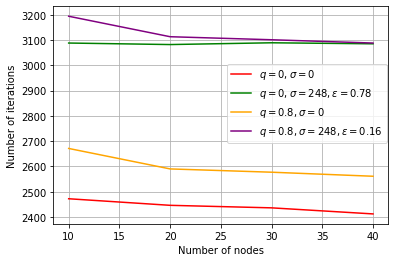

In [0]:
# Plot 

node_list = [10, 20, 30, 40]

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
#plt.ylim((1e-10, 1))
y_axis.sort()    
plt.clf
#plt.ylim((1e-12, 100))
#plt.xlim((1, 2600))
#plt.xscale('log')
# plt.yscale('log')
plt.grid()

plt.plot(node_list, a1[0], color='r', linestyle="-", label =r"$q = 0, \sigma = 0$")
plt.plot(node_list, a1[1], color='g', linestyle="-", label =r"$q = 0, \sigma = 248, \epsilon = 0.78$")
plt.plot(node_list, a1[2], color='orange', linestyle="-", label =r"$q = 0.8, \sigma = 0$")
plt.plot(node_list, a1[3], color='purple', linestyle="-", label =r"$q = 0.8, \sigma = 248, \epsilon = 0.16$")

plt.xlabel('Number of nodes')
plt.ylabel('Number of iterations')
# plt.legend()
plt.legend(bbox_to_anchor=(1.01, 0.76),loc='upper right')
# plt.savefig('/tmp/dp_consensus_num_nodes.eps',dpi=600,format='eps')